
🔄 MEMULAI VISUALISASI ROBUSTNESS (20 ITERASI)...


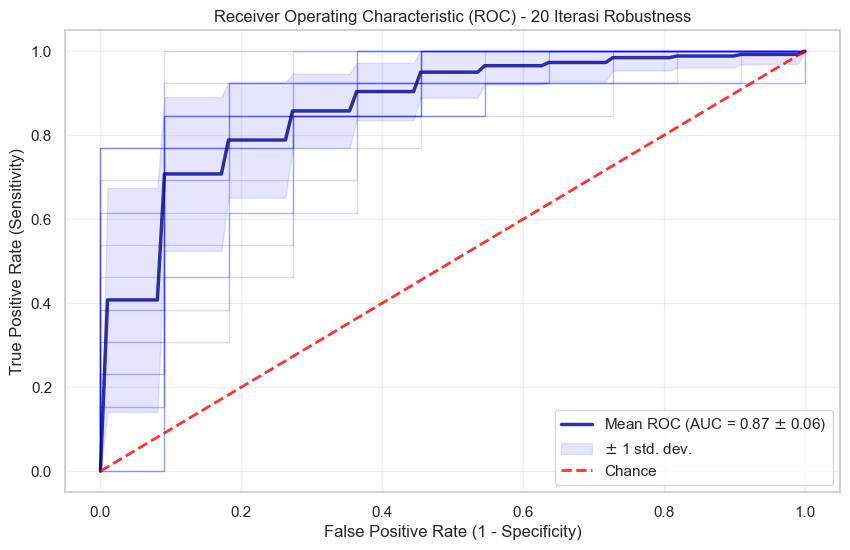


       LAPORAN VALIDASI STABILITAS
✅ Rata-rata AUC     : 0.8654
✅ AUC Tertinggi     : 0.9720
✅ Rata-rata Akurasi : 80.00%


In [6]:
# =================================================================
# 5. VALIDASI & VISUALISASI ROBUSTNESS (FINAL)
# =================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc

# Konfigurasi Plot
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 11})

print("\n🔄 MEMULAI VISUALISASI ROBUSTNESS (20 ITERASI)...")

# 1. Load Data
try:
    df_raw = pd.read_csv('../data/raw/dataR2.csv')
except:
    df_raw = pd.read_csv('data/raw/dataR2.csv') # Fallback path

df_raw = df_raw.rename(columns={'Classification': 'Diagnosis'})
df_raw = df_raw[df_raw['BMI'] <= 40] # Filter BMI

X_raw = df_raw[['Glucose', 'Resistin', 'Age', 'BMI']]
y_raw = df_raw['Diagnosis'] - 1

# Variabel untuk menyimpan hasil
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
accuracies = []

plt.figure(figsize=(10, 6))

# 2. Iterasi 20x
for i in range(20):
    # Split & Scale
    X_tr, X_ts, y_tr, y_ts = train_test_split(X_raw, y_raw, test_size=0.2, random_state=i, stratify=y_raw)
    sc = StandardScaler()
    X_tr_sc = sc.fit_transform(X_tr)
    X_ts_sc = sc.transform(X_ts)
    
    # Load & Retrain Model
    with open('../models/best_svm_optuna.pkl', 'rb') as f:
        base_model = pickle.load(f)
    model_loop = pickle.loads(pickle.dumps(base_model))
    model_loop.fit(X_tr_sc, y_tr)
    
    # Hitung Probabilitas & Metrik
    y_prob = model_loop.predict_proba(X_ts_sc)[:, 1]
    y_pred = model_loop.predict(X_ts_sc)
    
    # Simpan Akurasi & AUC
    accuracies.append(accuracy_score(y_ts, y_pred))
    roc_auc = roc_auc_score(y_ts, y_prob)
    aucs.append(roc_auc)
    
    # Hitung ROC untuk plotting
    fpr, tpr, _ = roc_curve(y_ts, y_prob)
    
    # Interpolasi agar grafik bisa dirata-rata
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    # Plot garis tipis untuk setiap iterasi (transparan)
    plt.plot(fpr, tpr, lw=1, alpha=0.15, color='blue')

# 3. Plot Garis Rata-rata (Mean ROC)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='darkblue',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2.5, alpha=.8)

# Plot Area Variasi (Standard Deviation)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='blue', alpha=.1,
                 label=r'$\pm$ 1 std. dev.')

# Plot Garis Diagonal
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red', label='Chance', alpha=.8)

# Dekorasi Plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) - 20 Iterasi Robustness')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# 4. Print Statistik Akhir
print("\n" + "="*50)
print("       LAPORAN VALIDASI STABILITAS")
print("="*50)
print(f"✅ Rata-rata AUC     : {np.mean(aucs):.4f}")
print(f"✅ AUC Tertinggi     : {np.max(aucs):.4f}")
print(f"✅ Rata-rata Akurasi : {np.mean(accuracies):.2%}")
print("="*50)